In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
df = pd.read_csv('CLEANDATA/Clean_MT.csv', index_col=False)
df.head(10)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
5,Morbid obesity. Laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","bariatrics, gastric bypass, eea anastomosis, r..."
6,"Liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","bariatrics, breast reconstruction, excess, lma..."
7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
8,Suction-assisted lipectomy - lipodystrophy of...,Bariatrics,Lipectomy - Abdomen/Thighs,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...","bariatrics, lipodystrophy, abd pads, suction-a..."
9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."


In [5]:
df['medical_specialty'].value_counts()

medical_specialty
 Surgery                          1021
 Orthopedic                        303
 Cardiovascular / Pulmonary        280
 Radiology                         251
 Consult - History and Phy.        234
 Gastroenterology                  195
 Neurology                         168
 General Medicine                  146
 SOAP / Chart / Progress Notes     142
 Urology                           140
 Obstetrics / Gynecology           130
 ENT - Otolaryngology               84
 Neurosurgery                       81
 Ophthalmology                      79
 Discharge Summary                  77
 Nephrology                         63
 Hematology - Oncology              62
 Pain Management                    58
 Office Notes                       44
 Pediatrics - Neonatal              42
 Podiatry                           42
 Emergency Room Reports             31
 Dermatology                        25
 Dentistry                          25
 Cosmetic / Plastic Surgery         25
 Letter

In [6]:
def PreProcess(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Lowercase the text
    tokens = [word.lower() for word in tokens]
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the text
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [7]:
PreProcess(df['transcription'].iloc[6])

'preoperative diagnosis deformity right breast excess soft tissue anterior abdomen lipodystrophy postoperative diagnosis deformity right breast excess soft tissue anterior abdomen lipodystrophy procedure revision right breast excision soft tissue fullness lateral abdomen liposuction supraumbilical anesthesia indication operation patient white female previously undergone latissimus dorsi flap implant breast reconstruction lateralization implant loss medial fullness desired correction felt mobilization implant medially would provide patient significant improvement discussed patient length patient also small dog ear flank area right latissimus flap harvest corrected also liposuction periumbilical infraumbilical abdomen desire great improvement superiorly felt candidate procedure discussed patient detail risk benefit potential complication discussed marked upright position taken operating room operative procedure patient taken operating room placed supine position following adequate induct

In [8]:
df = df[df['medical_specialty'].isin(df['medical_specialty'].value_counts()[df['medical_specialty'].value_counts() > 100].index)]

In [9]:
df['medical_specialty'].value_counts()

medical_specialty
 Surgery                          1021
 Orthopedic                        303
 Cardiovascular / Pulmonary        280
 Radiology                         251
 Consult - History and Phy.        234
 Gastroenterology                  195
 Neurology                         168
 General Medicine                  146
 SOAP / Chart / Progress Notes     142
 Urology                           140
 Obstetrics / Gynecology           130
Name: count, dtype: int64

In [10]:
df = df[~df['medical_specialty'].str.contains('Surgery|Consult - History and Phy.|General Medicine|SOAP / Chart / Progress Notes')]

In [11]:
df['medical_specialty'].value_counts()

medical_specialty
 Orthopedic                    303
 Cardiovascular / Pulmonary    280
 Radiology                     251
 Gastroenterology              195
 Neurology                     168
 Urology                       140
 Obstetrics / Gynecology       130
Name: count, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1467 entries, 3 to 3887
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        1467 non-null   object
 1   medical_specialty  1467 non-null   object
 2   sample_name        1467 non-null   object
 3   transcription      1467 non-null   object
 4   keywords           1467 non-null   object
dtypes: object(5)
memory usage: 68.8+ KB


In [14]:
df['p_transcription'] = df['transcription'].apply(PreProcess)

In [15]:
# pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [16]:
# X and y
X = df['p_transcription']
y = df['medical_specialty']

In [17]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.75      0.95      0.84        57
           Gastroenterology       0.89      0.74      0.81        43
                  Neurology       0.38      0.19      0.26        31
    Obstetrics / Gynecology       0.82      0.64      0.72        22
                 Orthopedic       0.60      0.94      0.73        62
                  Radiology       0.45      0.35      0.39        52
                    Urology       1.00      0.63      0.77        27

                   accuracy                           0.68       294
                  macro avg       0.70      0.63      0.65       294
               weighted avg       0.68      0.68      0.66       294



In [20]:
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams or unigrams + bigrams
    'tfidf__max_df': [0.85, 0.90, 1.0],  # Maximum document frequency
    'tfidf__min_df': [1, 2],  # Minimum document frequency
    'clf__alpha': [0.5, 1.0, 1.5]  # Smoothing parameter for Naive Bayes
}

In [21]:
# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

In [22]:
# Train the model using GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.5, 1.0, 1.5],
                         'tfidf__max_df': [0.85, 0.9, 1.0],
                         'tfidf__min_df': [1, 2],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [23]:
# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Make predictions on the test set with the best model
y_pred = grid_search.predict(X_test)

Best Hyperparameters: {'clf__alpha': 0.5, 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}


In [24]:
# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.73      0.86      0.79        57
           Gastroenterology       0.84      0.84      0.84        43
                  Neurology       0.46      0.42      0.44        31
    Obstetrics / Gynecology       0.83      0.86      0.84        22
                 Orthopedic       0.80      0.92      0.86        62
                  Radiology       0.39      0.27      0.32        52
                    Urology       0.96      0.93      0.94        27

                   accuracy                           0.72       294
                  macro avg       0.72      0.73      0.72       294
               weighted avg       0.70      0.72      0.71       294



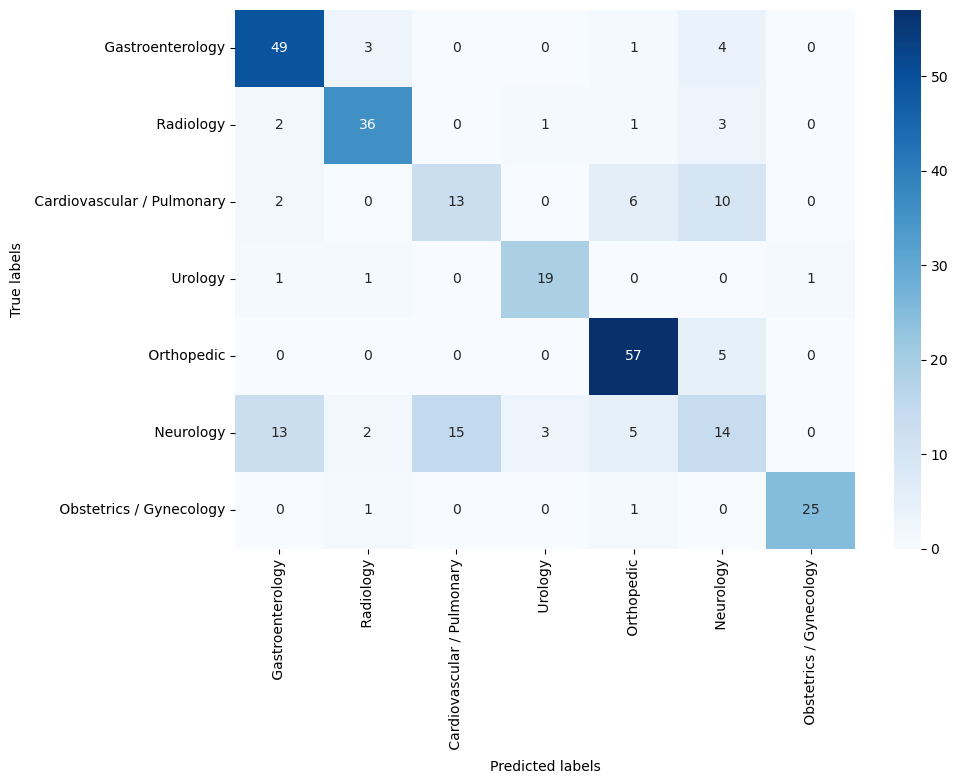

In [33]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
